In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 4 - Inferences with Gaussians
## 4.1 Inferring a mean and standard deviation


Inferring the mean and variance of a Gaussian distribution. 
$$ \mu \sim \text{Gaussian}(0, .001)  $$
$$ \sigma \sim \text{Uniform} (0, 10)  $$
$$ x_{i} \sim \text{Gaussian} (\mu, \frac{1}{\sigma^2})  $$


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu]
100%|██████████| 1500/1500.0 [00:02<00:00, 548.70it/s]
The acceptance probability does not match the target. It is 0.9465830505150119, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


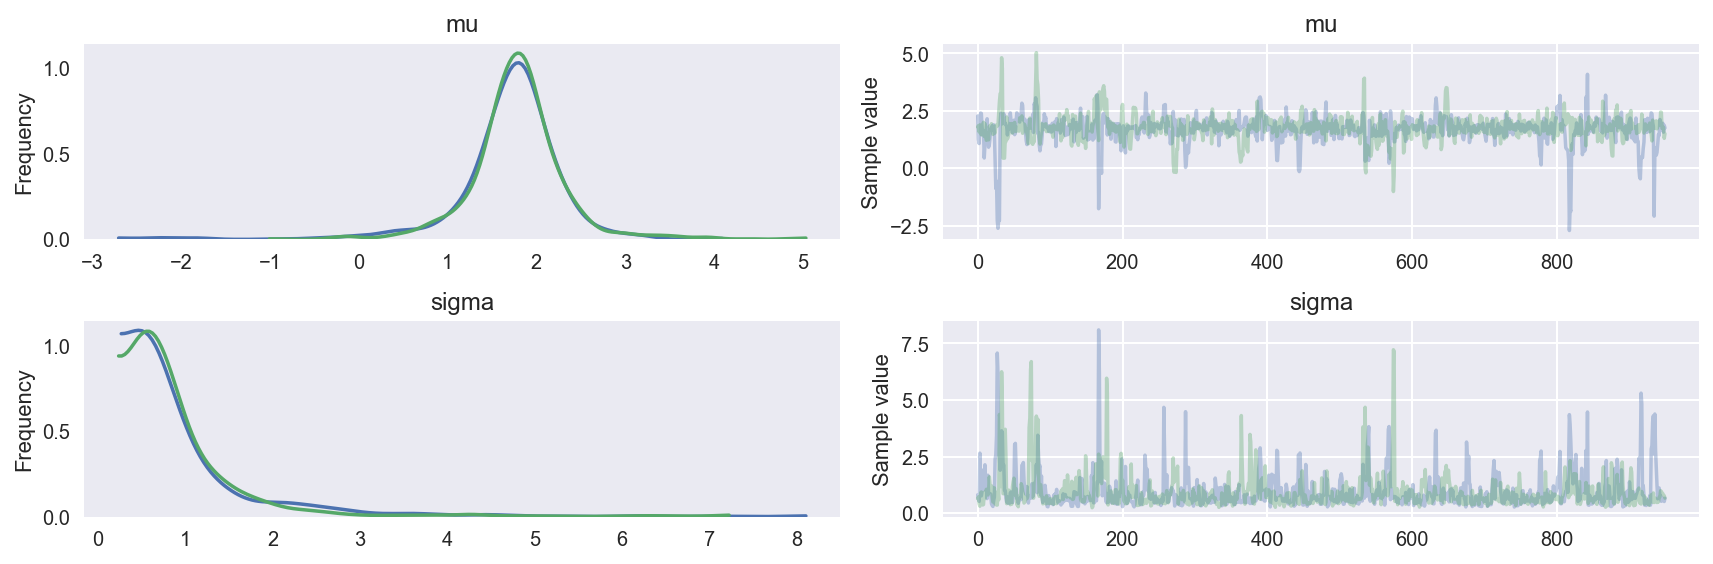

In [2]:
# Data
x = np.array([1.1, 1.9, 2.3, 1.8])
n = len(x)
    
with pm.Model() as model1:
    # prior
    mu = pm.Normal('mu', mu=0, tau=.001)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # observed
    xi = pm.Normal('xi',mu=mu, tau=1/(sigma**2), observed=x)
    # inference
    trace = pm.sample(1e3, cores=2)

pm.traceplot(trace[50:]);

The mu estimation is: 1.739
The sigma estimation is: 0.935


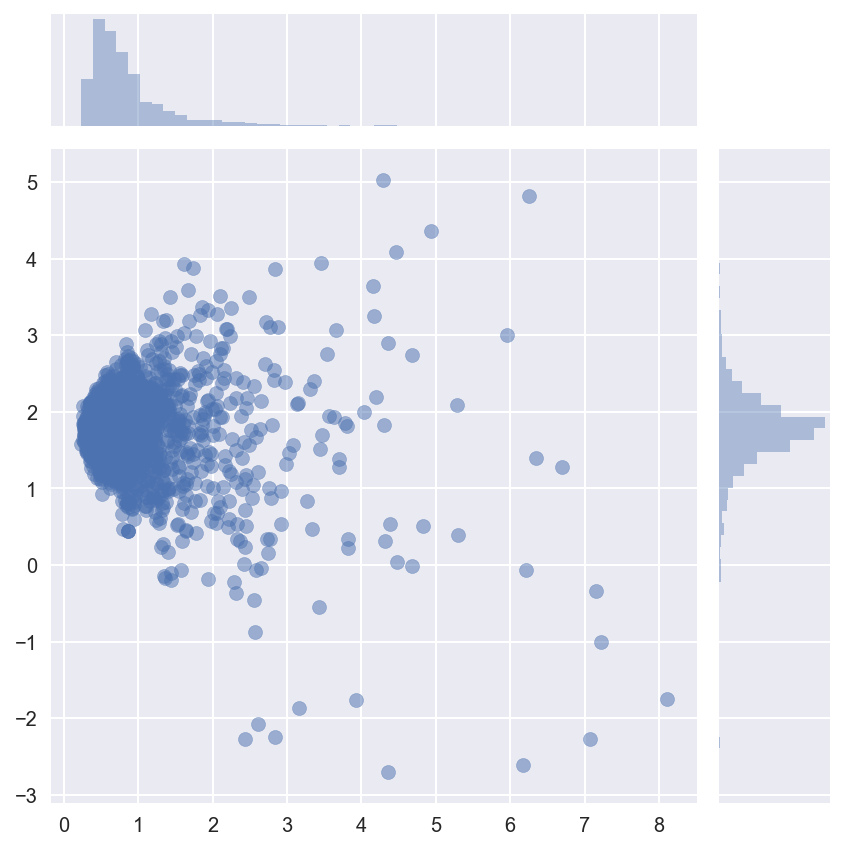

In [3]:
y = trace['mu']
x = trace['sigma']
sns.jointplot(x, y, kind='scatter', stat_func=None, alpha=.5);

print('The mu estimation is: %.3f' % y.mean())
print('The sigma estimation is: %.3f' % x.mean())

### Note from Junpeng Lao
There are might be divergence warning (Uniform prior on sigma is not a good idea in general), which you can further visualize below

Number of Divergent 0
Percentage of Divergent 0.00000


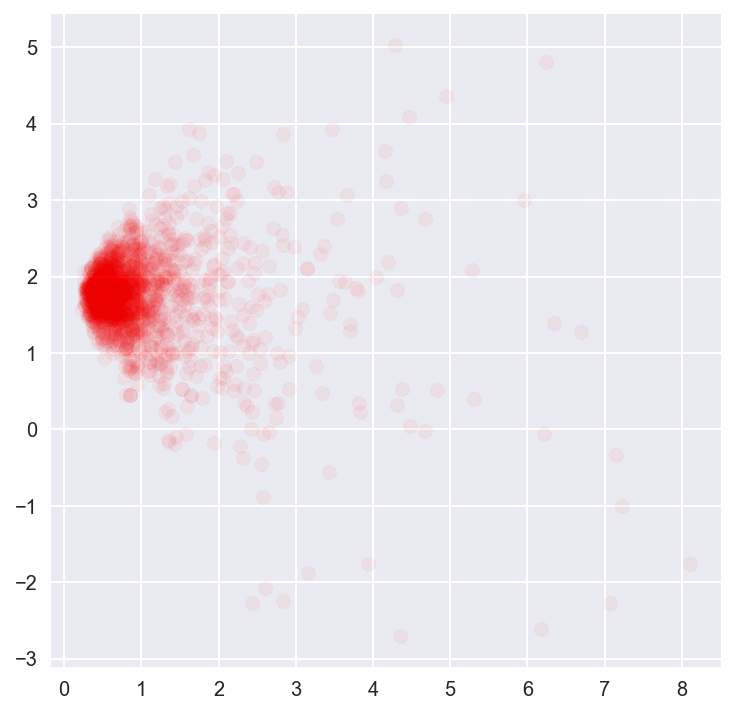

In [4]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace)
print('Percentage of Divergent %.5f' % divperc)

# scatter plot for the identifcation of the problematic neighborhoods in parameter space
plt.figure(figsize=(6, 6))
plt.scatter(x[divergent == 0], y[divergent == 0], color='r', alpha=.05)
plt.scatter(x[divergent == 1], y[divergent == 1], color='g', alpha=.5);

## 4.2 The seven scientists


The model:
$$ \mu \sim \text{Gaussian}(0, .001)  $$
$$ \lambda_{i} \sim \text{Gamma} (.001, .001)  $$
$$ \sigma = 1/{\sqrt\lambda_{i}} $$  
$$ x_{i} \sim \text{Gaussian} (\mu, \lambda_{i})  $$

The mean is the same for all seven scientists, while the standard deviations are different 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda1_log__, mu]
100%|██████████| 1500/1500 [00:05<00:00, 495.41it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,9.865854,0.190185,0.006531,9.457763e+00,10.207490,810.0,0.999559
lambda1__0,0.000701,0.000963,0.000021,3.393327e-09,0.002679,1729.0,0.999848
lambda1__1,0.026004,0.035988,0.000762,2.213264e-07,0.099839,2000.0,0.999503
lambda1__2,0.390120,0.615515,0.018360,7.289178e-06,1.485488,750.0,1.000013
lambda1__3,31.512392,47.308778,1.242406,1.594177e-04,139.439539,1260.0,0.999837
lambda1__4,14.494832,31.194612,0.748944,1.578921e-06,61.488083,1704.0,0.999792
lambda1__5,31.479531,52.580147,1.205836,2.206336e-04,132.715607,1499.0,1.002778
lambda1__6,22.621319,41.359723,1.034505,9.513185e-05,90.524246,1473.0,1.002328


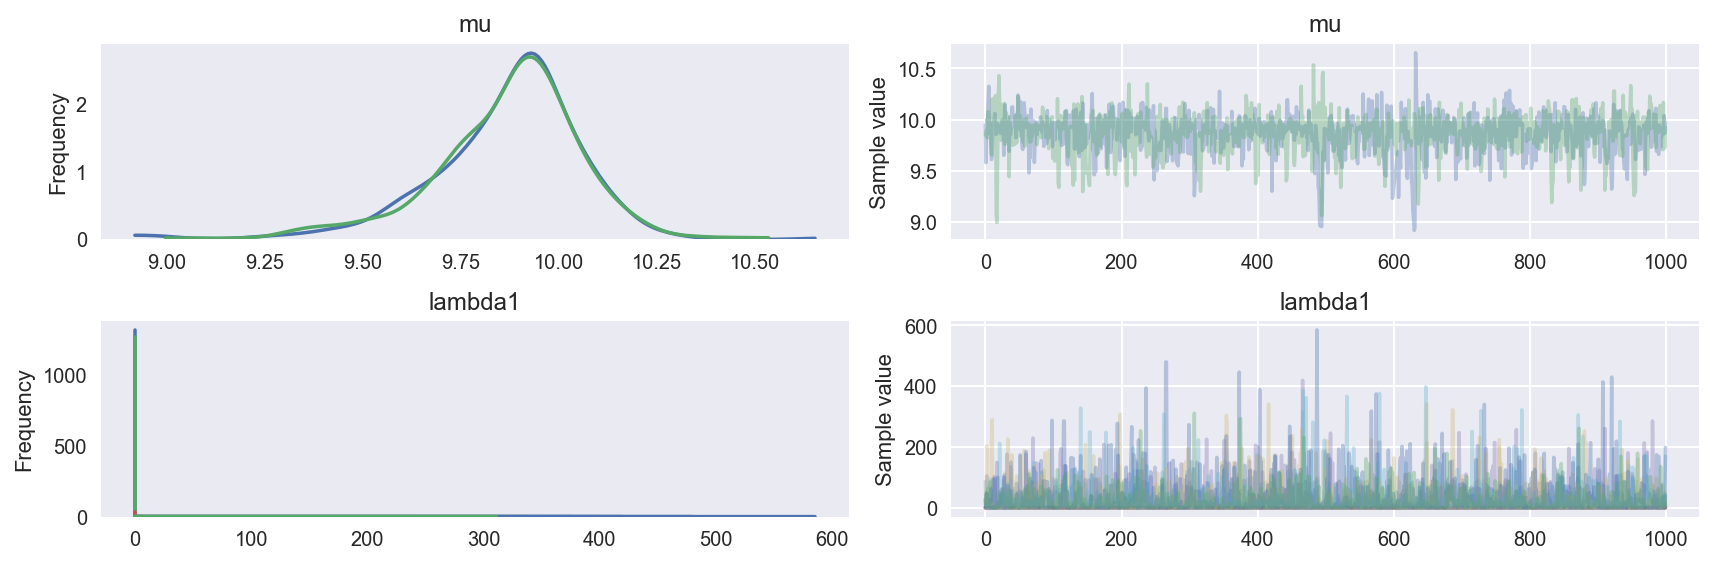

In [5]:
# data
x = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])
n = len(x)

with pm.Model() as model2: 
    # prior
    mu = pm.Normal('mu', mu=0, tau=.001)
    lambda1 = pm.Gamma('lambda1', alpha=.01, beta=.01, shape=n)
    # sigma = pm.Deterministic('sigma',1 / sqrt(lambda1))
    # observed
    xi = pm.Normal('xi', mu=mu, tau=lambda1, observed=x)

    # inference
    trace2 = pm.sample(1000, cores=2)

pm.traceplot(trace2);
pm.summary(trace2)

## 4.3 Repeated measurement of IQ


The model:
$$ \mu_{i} \sim \text{Uniform}(0, 300)  $$
$$ \sigma \sim \text{Uniform} (0, 100)  $$
$$ x_{ij} \sim \text{Gaussian} (\mu_{i}, \frac{1}{\sigma^2})  $$

Data Come From Gaussians With Different Means But Common Precision

In [8]:
# Data
y = np.array([[90, 95, 100], [105, 110, 115], [150, 155, 160]])
ntest = 3
nsbj = 3

import sys
eps = sys.float_info.epsilon

with pm.Model() as model3:
    # mu_i ~ Uniform(0, 300)
    # notices the shape here need to be properly 
    # initualized to have the right repeated measure
    mui = pm.Uniform('mui', 0, 300, shape=(nsbj, 1))

    # sg ~ Uniform(0, 100)
    # sg = pm.Uniform('sg', .0, 100)
    
    # It is more stable to use a Gamma prior
    lambda1 = pm.Gamma('lambda1', alpha=.01, beta=.01)
    sg = pm.Deterministic('sg',1 / np.sqrt(lambda1))
    
    # y ~ Normal(mu_i, sg)
    yd = pm.Normal('y', mu=mui, sd=sg, observed=y)
    
    trace3 = pm.sample(1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda1_log__, mui_interval__]
100%|██████████| 1500/1500 [00:05<00:00, 289.33it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mui__0_0,94.874648,3.692161,0.098853,87.448974,102.240460,1657.0,0.999925
mui__1_0,110.101733,3.613046,0.103775,101.953837,116.721608,1208.0,1.000201
mui__2_0,155.110487,3.506717,0.077486,148.544621,162.855340,1687.0,0.999661
lambda1,0.039824,0.023312,0.000666,0.004412,0.082923,949.0,0.999639
sg,5.801882,2.125995,0.070157,2.759583,9.978138,633.0,0.999691


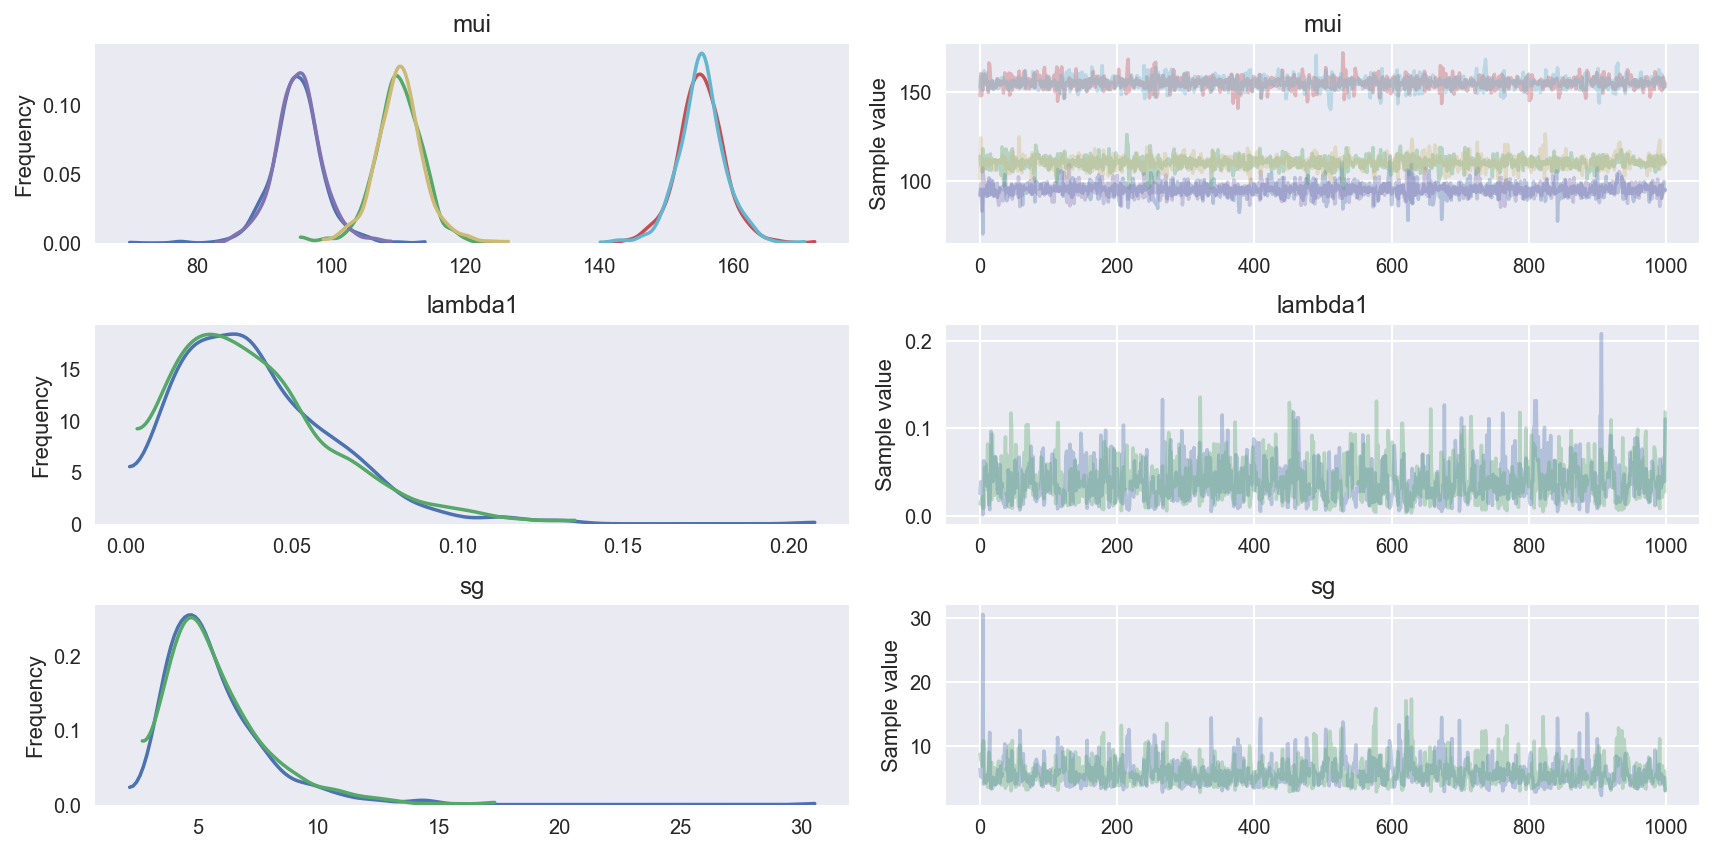

In [9]:
pm.traceplot(trace3);
pm.summary(trace3)